# Банковский кредитный скоринг

<p>Скоринг – используемая банками система оценки клиентов, в основе которой заложены статистические методы. Как правило, это компьютерная программа, куда вводятся данные потенциального заемщика. В ответ выдается результат – стоит ли предоставлять ему кредит.</p> 
<p>Задачи проекта:</p>
<p>1.Провести разведовательный анализ данных.</p>
<p>2.Обучить модель логистической регрессии, подобрать лучшие параметры.</p>
<img src="https://upload.wikimedia.org/wikipedia/commons/c/ca/BilleteiNTER_II.jpg" style="width:500px;height:400px;">

<p>Описание данных:</p>
<ul>
<li>client_id - идентификатор клиента</li>
<li>education - уровень образования</li>
<li>sex - пол заемщика</li>
<li>age - возраст заемщика</li>
<li>car - флаг наличия автомобиля</li>
<li>car_type - флаг автомобиля иномарки</li>
<li>decline_app_cnt - количество отказанных прошлых заявок</li>
<li>good_work - флаг наличия “хорошей” работы</li>
<li>bki_request_cnt - количество запросов в БКИ</li>
<li>home_address - категоризатор домашнего адреса</li>
<li>work_address - категоризатор рабочего адреса</li>
<li>income - доход заемщика</li>
<li>foreign_passport - наличие загранпаспорта</li>
<li>sna - связь заемщика с клиентами банка</li>
<li>first_time - давность наличия информации о заемщике</li>
<li>score_bki - скоринговый балл по данным из БКИ</li>
<li>region_rating - рейтинг региона</li>
<li>app_date - дата подачи заявки</li>
<li>default - флаг дефолта по кредиту</li>
</ul>

## 1. Импорт библиотек 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve,confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV
RANDOM_SEED=42
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# списки для различных категорий данных
num_cols = []
bin_cols = []
kat_cols = []

# дополнительные функции для анализа данных


def info_kat(data, col):
    kat_cols.append(col)
    print('Количество пропущенных значений:', data[col].isnull().sum())
    print('Количество уникальных значений:', data[col].nunique())
    display(data[col].value_counts())
    fig, ax = plt.subplots(1, 2, figsize=(12, 7))
    sns.countplot(x=col, data=data, ax=ax[0])
    sns.countplot(x=col, data=data[data['train']==1], hue='default', ax=ax[1])


def bin_kat(data, col):
    bin_cols.append(col)
    print('Количество пропущенных значений:', data[col].isnull().sum())
    print('Количество уникальных значений:', data[col].nunique())
    display(data[col].value_counts())
    fig, ax = plt.subplots(1, 2, figsize=(12, 7))
    sns.countplot(x=col, data=data, ax=ax[0])
    sns.countplot(x=col, data=data[data['train']==1], hue='default', ax=ax[1])


def num_kat(data, col):
    num_cols.append(col)
    print('Количество пропущенных значений:', data[col].isnull().sum())
    print('\nРасспределение уникальных значений:')
    display(data[col].value_counts().head(10))
    print('Основная статистика:')
    display(data[col].describe())
    fig, ax = plt.subplots(1, 2, figsize=(12, 7))
    ax[0].hist(data[col])
    sns.boxplot(x='default', y=col, data=data[data['train']==1], ax=ax[1])

    
# функция для исследония данных на выбросы
def vubros(x):
    median = pd.DataFrame(x).median()[0]
    IQR = pd.DataFrame(x).quantile(0.75)[0] - pd.DataFrame(x).quantile(0.25)[0]
    perc25 = pd.DataFrame(x).quantile(0.25)[0]
    perc75 = pd.DataFrame(x).quantile(0.75)[0]
    df = pd.Series(x).loc[pd.Series(x).between(
        perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    plt.hist(df, bins=10, range=(0, (perc75 + 1.5*IQR)*1.2), label='IQR')
    plt.legend()


# функция, возвращающая границы для удаления выбросов
def interval_vubros(x):
    median = pd.DataFrame(x).median()[0]
    IQR = pd.DataFrame(x).quantile(0.75)[0] - pd.DataFrame(x).quantile(0.25)[0]
    perc25 = pd.DataFrame(x).quantile(0.25)[0]
    perc75 = pd.DataFrame(x).quantile(0.75)[0]
    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR
    return(f, l)

## 2. Загрузка данных 

In [3]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

In [4]:
print('Тренировочный датасет содержит {} строк и {} столбцов'.format(df_train.shape[0],df_train.shape[1]))
print('Тестовый датасет содержит {} строк и {} столбцов'.format(df_test.shape[0],df_test.shape[1]))

Тренировочный датасет содержит 73799 строк и 19 столбцов
Тестовый датасет содержит 36349 строк и 18 столбцов


In [5]:
#рассмотрим общую информацию
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [6]:
df_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [7]:
# Объединим данные, для лучшей предобработки
df_train['train'] = 1
df_test['train'] = 0
df = pd.concat([df_train, df_test]).reset_index()

## 3. Разведывательный анализ 

### Education - уровень образования

Количество пропущенных значений: 478
Количество уникальных значений: 5


SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

None

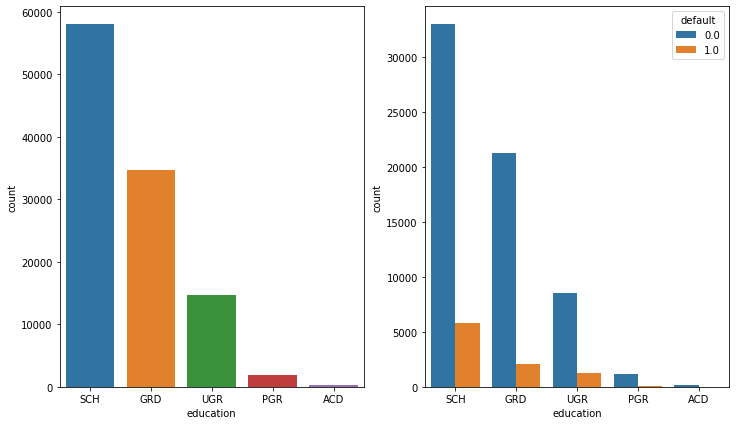

In [8]:
display(info_kat(df,'education'))

In [9]:
# Заполним пропущенные значения новой величиной
df['education'].fillna('NOT',inplace=True)
df_train['education'].fillna('NOT',axis=0,inplace=True)
df_test['education'].fillna('NOT',axis=0,inplace=True)

### sex - пол заемщика

Количество пропущенных значений: 0
Количество уникальных значений: 2


F    61836
M    48312
Name: sex, dtype: int64

None

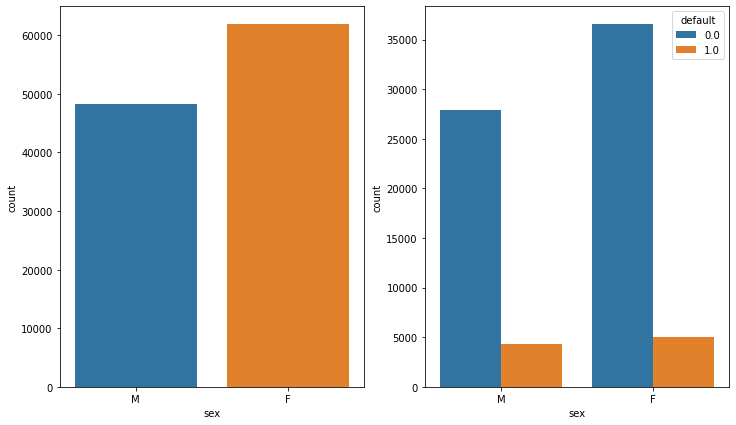

In [10]:
display(bin_kat(df,'sex'))

Больше заемщиков - женщин. Проверим, кому в процентном соотношении дают больше кредитов, женщинам или мужчинам?

In [11]:
df_train.groupby(['sex', 'default'])['client_id'].agg('count')

sex  default
F    0          36523
     1           5039
M    0          27904
     1           4333
Name: client_id, dtype: int64

In [12]:
print('Процент мужчин, получающих положительный ответ по кредиту:',
      round(4333/df[df['sex'] == 'M']['index'].count()*100, 2))
print('Процент женщин, получающих положительный ответ по кредиту:',
      round(5039/df[df['sex'] == 'F']['index'].count()*100,2))

Процент мужчин, получающих положительный ответ по кредиту: 8.97
Процент женщин, получающих положительный ответ по кредиту: 8.15


Можно сделать вывод, что пол никак не влият на получение кредита.

### age - возраст заемщика

Количество пропущенных значений: 0

Расспределение уникальных значений:


31    4084
28    4035
30    4035
27    3964
29    3940
26    3780
32    3773
34    3548
33    3499
35    3386
Name: age, dtype: int64

Основная статистика:


count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64

None

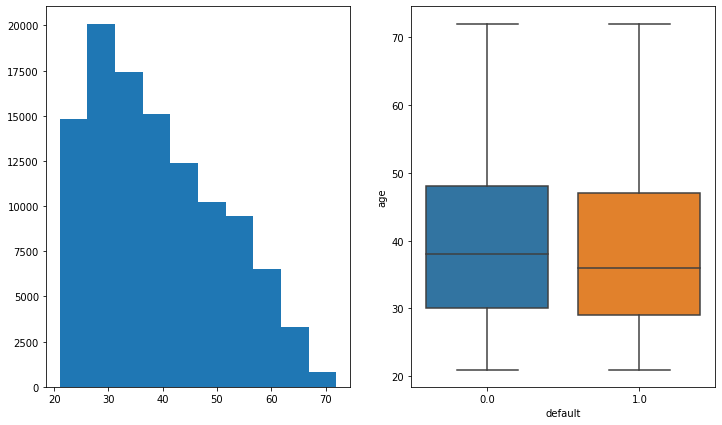

In [13]:
display(num_kat(df,'age'))

Средний возраст заемщика 39 лет, выбросов нет, т.к. минимальное значение 21, а максимальное 72, что допустимо.Также видно, что чуть больше кредитов выдают людям по моложе.

### car - флаг наличия автомобиля

Количество пропущенных значений: 0
Количество уникальных значений: 2


N    74290
Y    35858
Name: car, dtype: int64

None

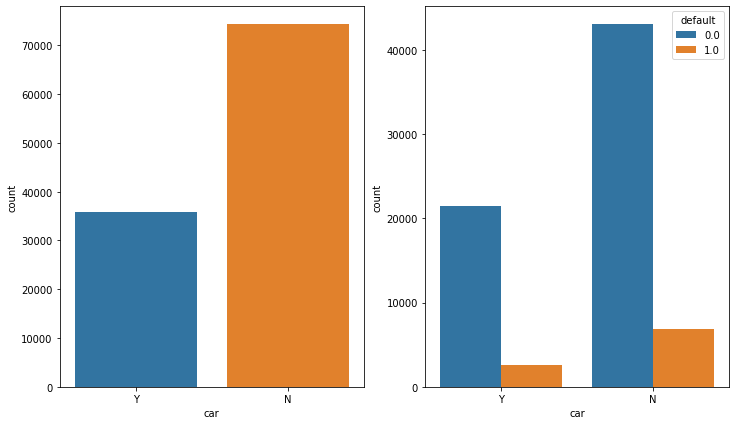

In [14]:
display(bin_kat(df,'car'))

In [15]:
print(df.groupby(['car', 'default'])['index'].agg('count'))
print('Процент людей, не имеющих автомобиль, получающих положительный ответ по кредиту:',
      round(6825/df[df['car'] == 'N']['index'].count()*100, 2))
print('Процент людей, имеющих автомобиль, получающих положительный ответ по кредиту:',
      round(2547/df[df['car'] == 'Y']['index'].count()*100,2))

car  default
N    0.0        43007
     1.0         6825
Y    0.0        21420
     1.0         2547
Name: index, dtype: int64
Процент людей, не имеющих автомобиль, получающих положительный ответ по кредиту: 9.19
Процент людей, имеющих автомобиль, получающих положительный ответ по кредиту: 7.1


Как видно, наличие автомобиля, не повышает шансы на положительный ответ банка, т.к. процент людей без машин, получают кредиты больше.

### car_type - флаг автомобиля иномарки

Количество пропущенных значений: 0
Количество уникальных значений: 2


N    89140
Y    21008
Name: car_type, dtype: int64

None

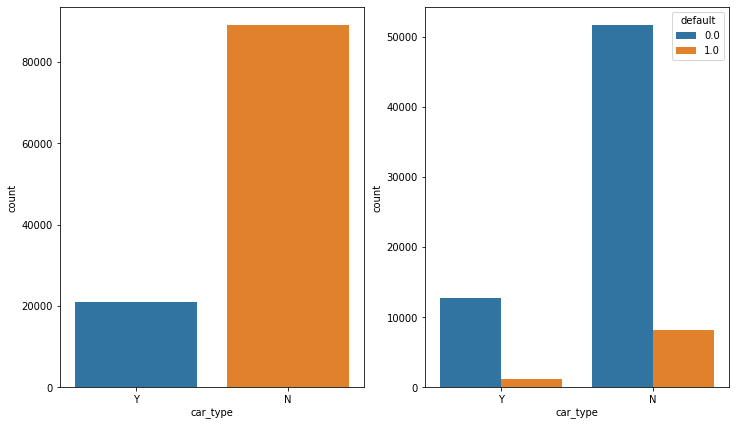

In [16]:
display(bin_kat(df,'car_type'))

### decline_app_cnt - количество отказанных прошлых заявок

Количество пропущенных значений: 0

Расспределение уникальных значений:


0    91471
1    12500
2     3622
3     1365
4      606
5      255
6      156
7       58
8       37
9       29
Name: decline_app_cnt, dtype: int64

Основная статистика:


count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

None

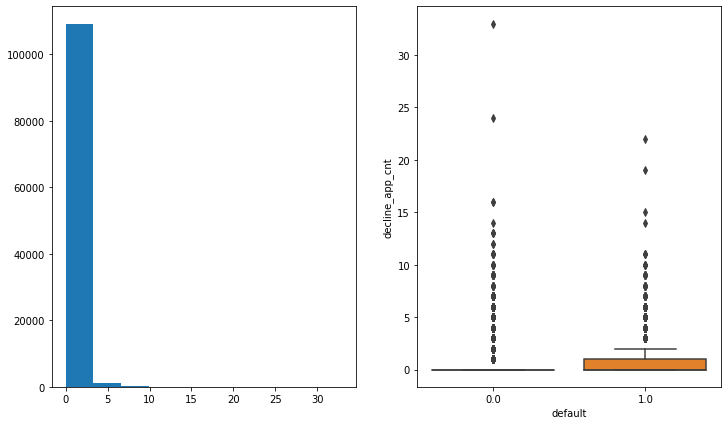

In [17]:
display(num_kat(df,'decline_app_cnt'))

Видим, что очень много выбросов, сократим значение отказов до 15

In [18]:
df['decline_app_cnt']=df.decline_app_cnt.apply(lambda x: 15 if x>15 else x)
df_train['decline_app_cnt']=df_train.decline_app_cnt.apply(lambda x: 15 if x>15 else x)
df_test['decline_app_cnt']=df_test.decline_app_cnt.apply(lambda x: 15 if x>15 else x)

### good_work - флаг наличия “хорошей” работы

Количество пропущенных значений: 0
Количество уникальных значений: 2


0    91917
1    18231
Name: good_work, dtype: int64

None

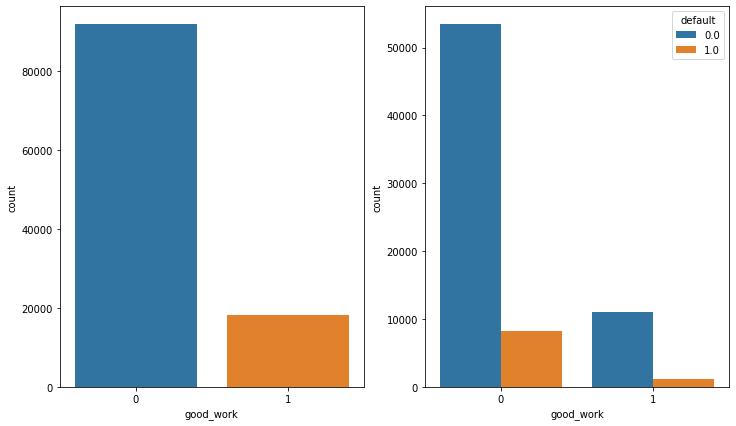

In [19]:
display(bin_kat(df,'good_work'))

Количество заемщиков не имеющих хорошую работу значительно превышает, при этом не видно, чтобы наличие хорошей работы повышало шансы на получения заема.

### bki_request_cnt - количество запросов в БКИ

Количество пропущенных значений: 0

Расспределение уникальных значений:


0    28908
1    27295
2    20481
3    13670
4     8406
5     4960
6     2500
7     1292
8      735
9      459
Name: bki_request_cnt, dtype: int64

Основная статистика:


count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64

None

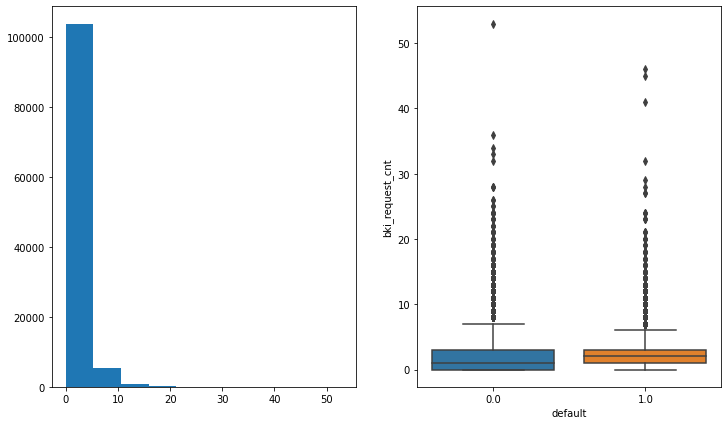

In [20]:
display(num_kat(df,'bki_request_cnt'))

Переменная имеет много выбросов, для всех значений больше 7.

In [21]:
df['bki_request_cnt']=df.bki_request_cnt.apply(lambda x: 7 if x>7 else x)
df_train['bki_request_cnt']=df_train.bki_request_cnt.apply(lambda x: 7 if x>7 else x)
df_test['bki_request_cnt']=df_test.bki_request_cnt.apply(lambda x: 7 if x>7 else x)

### home_address - категоризатор домашнего адреса

Количество пропущенных значений: 0
Количество уникальных значений: 3


2    59591
1    48688
3     1869
Name: home_address, dtype: int64

None

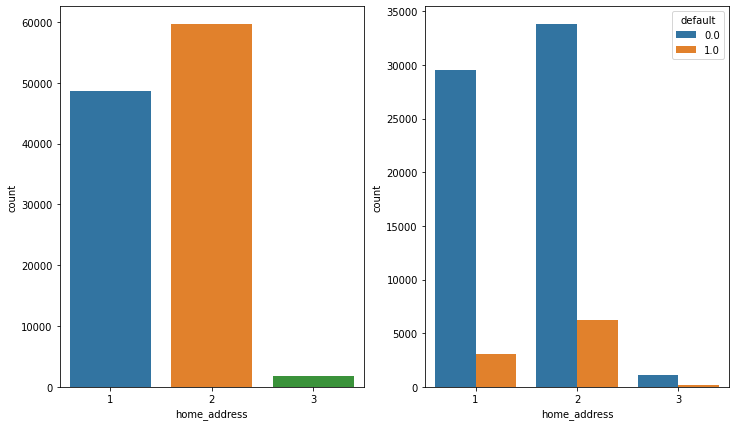

In [22]:
display(info_kat(df,'home_address'))

### work_address - категоризатор рабочего адреса

Количество пропущенных значений: 0
Количество уникальных значений: 3


3    67113
2    30761
1    12274
Name: work_address, dtype: int64

None

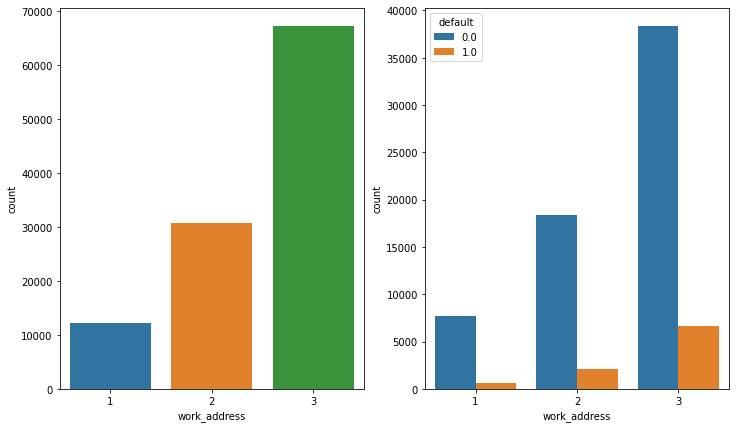

In [23]:
display(info_kat(df,'work_address'))

### income - доход заемщика

Количество пропущенных значений: 0

Расспределение уникальных значений:


30000    10437
25000     9090
20000     8174
40000     7383
50000     6742
35000     6319
15000     5874
60000     3818
45000     3670
18000     2732
Name: income, dtype: int64

Основная статистика:


count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

None

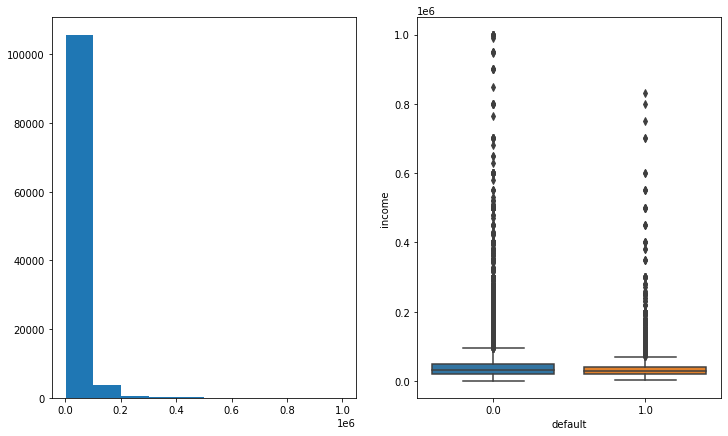

In [24]:
display(num_kat(df, 'income'))

По графикам, нет ярковыраженной зависимости от положительного результата и размера дохода.

25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].


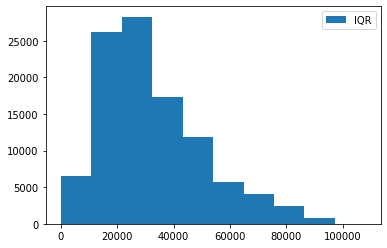

In [25]:
vubros(df['income'])

### foreign_passport - наличие загранпаспорта

Количество пропущенных значений: 0
Количество уникальных значений: 2


N    93721
Y    16427
Name: foreign_passport, dtype: int64

None

None

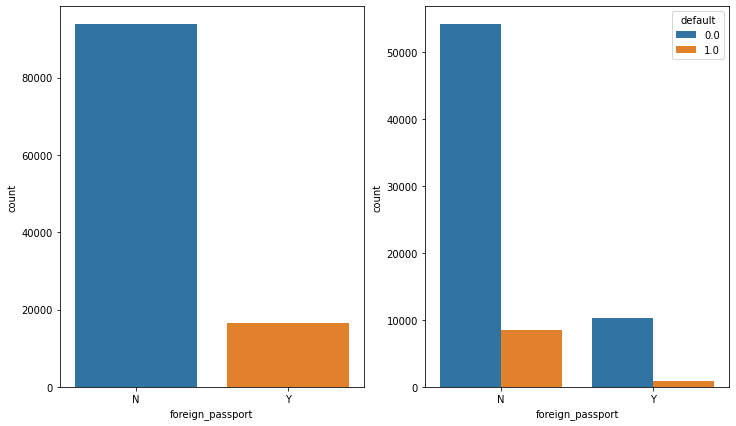

In [26]:
display(display(bin_kat(df,'foreign_passport')))

### sna - связь заемщика с клиентами банка

Количество пропущенных значений: 0
Количество уникальных значений: 4


1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64

None

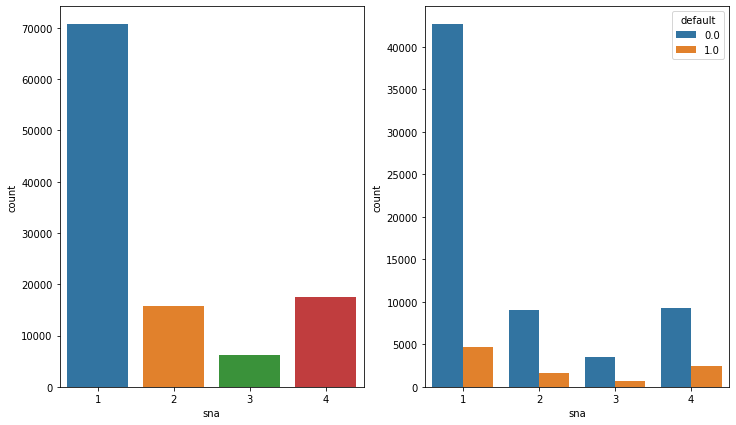

In [27]:
display(info_kat(df,'sna'))

### first_time - давность наличия информации о заемщике 

Количество пропущенных значений: 0
Количество уникальных значений: 4


3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64

None

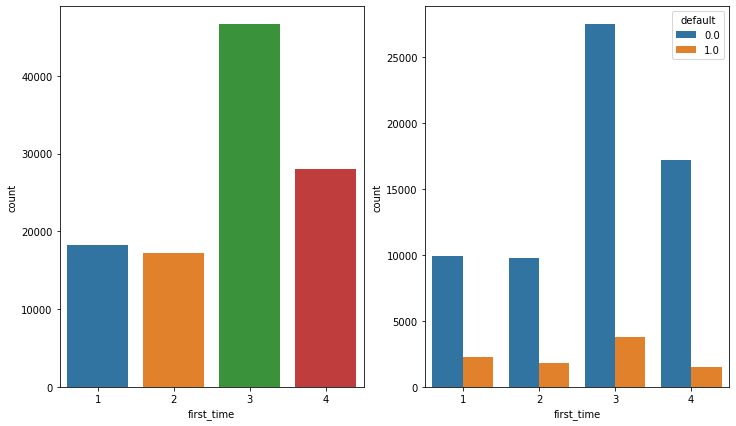

In [28]:
display(info_kat(df,'first_time'))

### score_bki - скоринговый балл по данным из БКИ

Количество пропущенных значений: 0

Расспределение уникальных значений:


-1.775263    517
-2.104211    454
-2.225004    424
-2.169664    375
-2.024100    278
-1.920823    270
-2.387268    238
-1.526422    207
-2.447239    207
-2.272941    176
Name: score_bki, dtype: int64

Основная статистика:


count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64

None

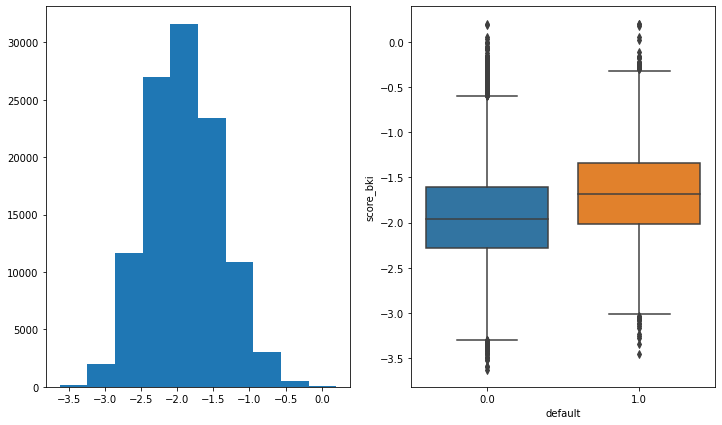

In [29]:
display(num_kat(df, 'score_bki'))

По графику видно, что величина предположительно распределена по нормальному закону. Заемщики получающие положительный результат, в среднем имеют большую оценку. 

### region_rating - рейтинг региона

Количество пропущенных значений: 0
Количество уникальных значений: 7


50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

None

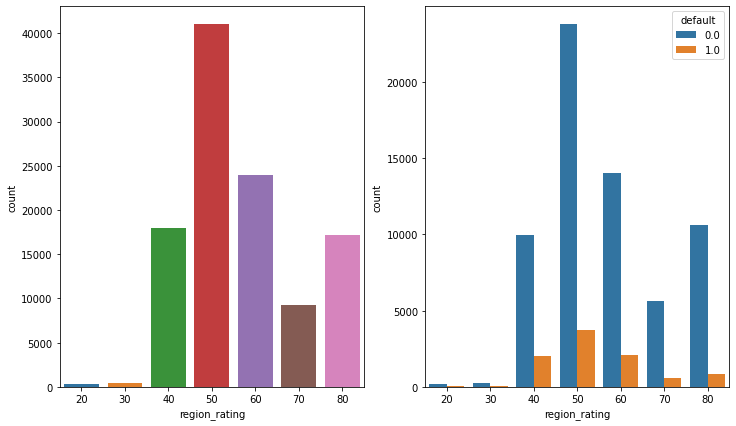

In [30]:
display(info_kat(df,'region_rating'))

### app_date - дата подачи заявки 

In [31]:
df['app_date'].value_counts()

18MAR2014    1491
19MAR2014    1363
17MAR2014    1350
31MAR2014    1317
07APR2014    1296
             ... 
20APR2014     359
07JAN2014     349
03JAN2014     313
02JAN2014     204
01JAN2014      56
Name: app_date, Length: 120, dtype: int64

Все операции проводились в 2014 году, интересно, влиет ли както месяц, на результат скоринга.

In [32]:
df['month']=df['app_date'].apply(lambda x:x[2:-4])
df_train['month']=df_train['app_date'].apply(lambda x:x[2:-4])
df_test['month']=df_test['app_date'].apply(lambda x:x[2:-4])

In [33]:
df['month'].value_counts()

MAR    31597
FEB    27097
APR    26266
JAN    25188
Name: month, dtype: int64

Количество пропущенных значений: 0
Количество уникальных значений: 4


MAR    31597
FEB    27097
APR    26266
JAN    25188
Name: month, dtype: int64

None

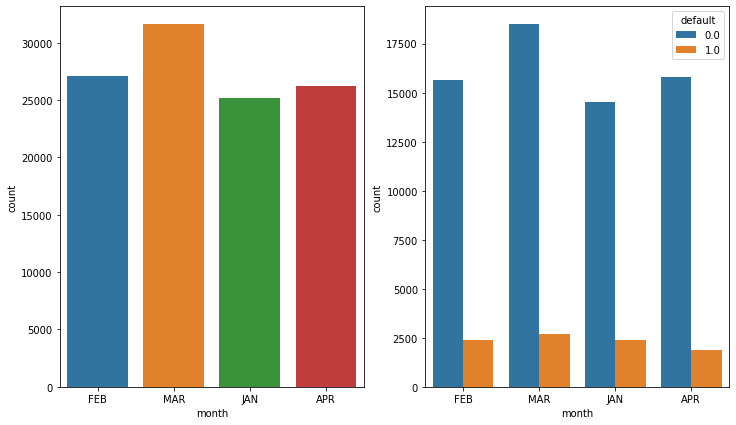

In [34]:
display(info_kat(df,'month'))

Получается, что в январе положительный ответ получали, больше процентов заявок, чем в январе и апреле, хотя количество заемщиков, в эти месяцы превышало. Рассмотрим день подачи заявки.

In [35]:
df['day']=df['app_date'].apply(lambda x:x[:2])
df_train['day']=df_train['app_date'].apply(lambda x:x[:2])
df_test['day']=df_test['app_date'].apply(lambda x:x[:2])

Количество пропущенных значений: 0
Количество уникальных значений: 31


17    4454
28    4338
18    4321
21    4230
11    4037
24    4035
14    3985
27    3924
15    3916
10    3836
04    3830
03    3818
20    3807
19    3737
22    3704
07    3642
05    3587
12    3559
25    3533
13    3471
16    3444
06    3412
09    3214
26    3141
01    2937
23    2899
30    2774
08    2747
02    2730
29    2553
31    2533
Name: day, dtype: int64

None

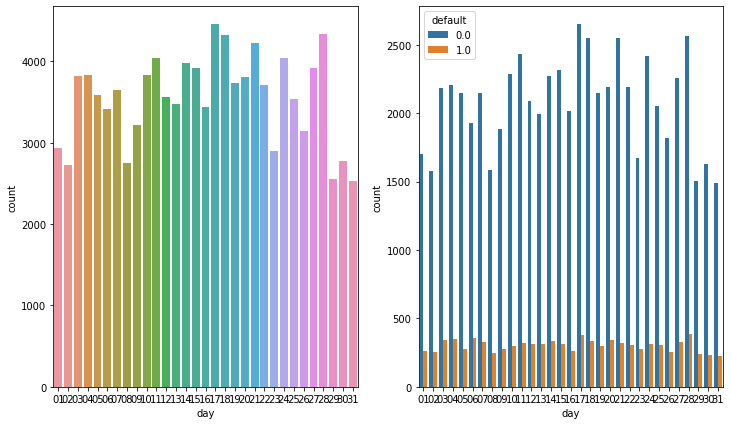

In [36]:
display(info_kat(df,'day'))

### default - флаг дефолта по кредиту

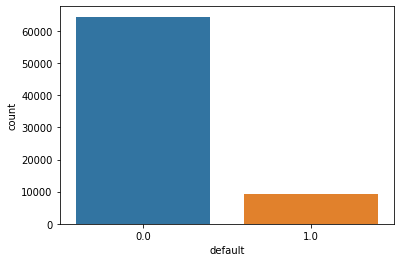

In [37]:
# Рассмотрим целевой признак
sns.countplot(x='default',data=df)

Выборка не сбалансированная, количество людей получивших отказ в заеме, значительно превышает, людей, которые получили заем.

## 4. Предобработка данных

### Числовые признаки

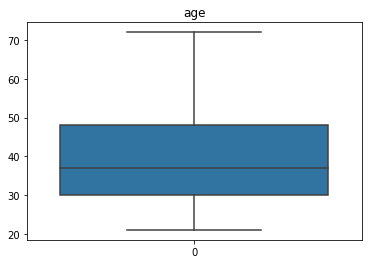

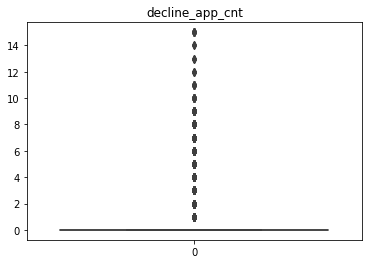

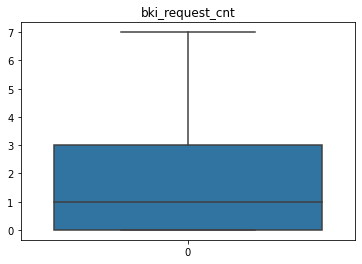

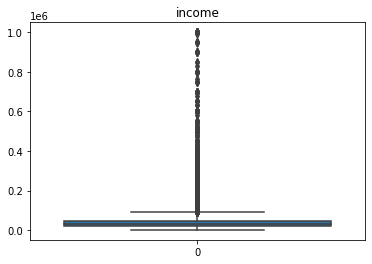

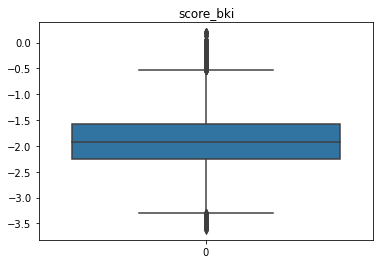

In [38]:
for i in num_cols:
    plt.figure()
    sns.boxplot(data=df[i])
    plt.title(i)
    plt.show()

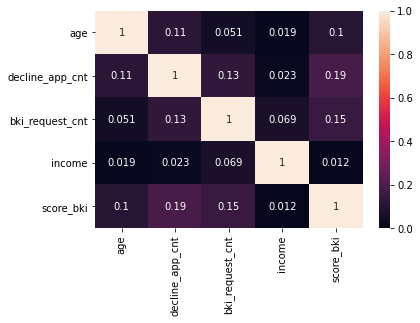

In [39]:
# т.к. логистическая регрессия - линейная модель, важно не допустить мультиколлинеарность признаков
sns.heatmap(df[num_cols].corr().abs(), annot=True, vmin=0, vmax=1)

Коэффициент корреляции не превышает 0,19, а следовательно - мультиколлинеарность отсутствует.

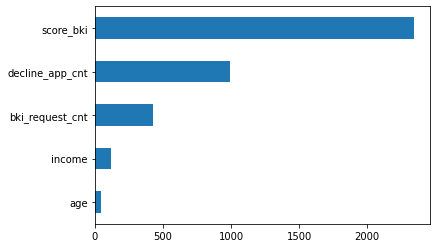

In [40]:
# определим наиболее значимые признаки
imp_num = pd.Series(f_classif(df_train[num_cols], df_train['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [41]:
# нормализуем данные, т.к. дисперсии числовых признаков сильно отличаются друг от друга
scaler= StandardScaler() 
scaler.fit_transform(df[num_cols])
df_train[num_cols]=scaler.transform(df_train[num_cols])
df_test[num_cols]=scaler.transform(df_test[num_cols])

### Биноминальные признаки 

In [42]:
bin_cols

['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [43]:
# перекодируем биноминальные данные
bin_c=['sex', 'car', 'car_type', 'foreign_passport']
label_encoder = LabelEncoder()

for column in bin_c:
    df[column]=label_encoder.fit_transform(df[column])
    df_train[column]=label_encoder.transform(df_train[column])
    df_test[column]=label_encoder.transform(df_test[column])

In [44]:
df.head()

,index,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,month,day
0,0,25905,01FEB2014,SCH,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0.0,1,FEB,01
1,1,63161,12MAR2014,SCH,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0.0,1,MAR,12
2,2,25887,01FEB2014,SCH,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0.0,1,FEB,01
3,3,16222,23JAN2014,SCH,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0.0,1,JAN,23
4,4,101655,18APR2014,GRD,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0.0,1,APR,18


### Категориальные признаки 

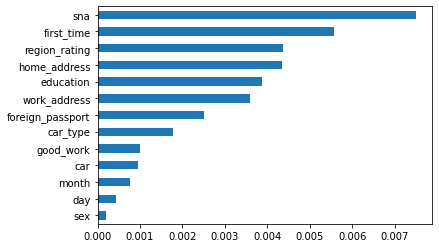

In [45]:
# преобразуем категориальные признаки, представленные текстовыми значениями
col1=['education','month','day']
df_train1=df_train.copy(deep=True)

for x in col1:
    df[x]=label_encoder.fit_transform(df[x])
    df_train1[x]=label_encoder.transform(df_train1[x])
df_train['day']=label_encoder.fit_transform(df_train['day'])
df_test['day']=label_encoder.transform(df_test['day'])

# проверяем значимость признаков
imp_cat = pd.Series(mutual_info_classif(df_train1[bin_cols + kat_cols], df_train1['default'],
                                     discrete_features =True), index = bin_cols + kat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [46]:
# Создаем дамми переменные
coll1=['education','month','sna','first_time','region_rating','home_address']
for col1 in coll1:
  df1=pd.get_dummies(df_train[col1],prefix=col1)
  df_train=pd.concat([df_train,df1],axis=1)
  df_train.drop([col1],axis=1,inplace=True)
  df2=pd.get_dummies(df_test[col1],prefix=col1)
  df_test=pd.concat([df_test,df2],axis=1)
  df_test.drop([col1],axis=1,inplace=True)  

## Обучение модели 

In [47]:
# Удалим малозначащие признаки и лишние признаки для дамми переменных
Y = df_train['default']
X = df_train.drop(['train','default','client_id','app_date','education_ACD','sna_4','first_time_3','region_rating_70',
                   'home_address_2','foreign_passport'],axis=1)
df_test.drop(['train','app_date','education_ACD','sna_4','first_time_3','region_rating_70','home_address_2',
              'foreign_passport'],axis=1,inplace=True)


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

### Logistic Regression

In [49]:
model=LogisticRegression(C=1291,  penalty='l2',random_state=RANDOM_SEED)
model.fit(X_train,y_train)


LogisticRegression(C=1291, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

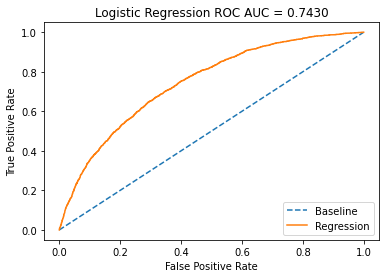

In [50]:
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()
#0.7437

In [51]:
# рассчитаем метрики
confusion_matrix(y_test,model.predict(X_test))

array([[12867,    66],
       [ 1783,    44]])

In [52]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(random_state=RANDOM_SEED)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0,scoring='roc_auc')

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1291.5496650148827


## Предсказание на тестовой выборке 

In [53]:
model = LogisticRegression(C=1291,                            
                           penalty='l2',  
                           random_state=RANDOM_SEED,
                           max_iter=1000)

model.fit(X_train, y_train)
submit = pd.DataFrame(df_test.client_id)
y_pred_prob = model.predict_proba(df_test.drop('client_id',axis=1))
submit['default']=y_pred_prob[:,1]
submit.to_csv('submission.csv', index=False)

Вывод: выборка не сбалансированная, классификатор очень точно предсказывает 0 класс, но неверно предсказывает 1 класс, ошибочно относя его к 0 классу. Удаление части тренировочной выборки, для баланса классов, не привели к удовлетворительному качеству, т.к. было удалено больше половины данных и их стало не достаточно, для хорошего обучения логистической регрессии.